# Image Classification: Implementation of ResNet from scratch

In this second notebook, we implement the classification of the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), containing 32x32 colour images divided into 10 classes (cats, birds, airplanes, etc.).

Contrary to our first work, where we used transfer learning, here, we have to build a Residual Neuronal Newtork ([ResNet](https://arxiv.org/abs/1512.03385)) and train it by ourselves, to differentialte the different classes of the dataset.

Indeed, the **pre-trained** models of *torchvision* are trained on large size images, and therefore are not adapted to smaller images like the ones of the CIFAR10 dataset (see the introductive remarks of the previous notebook).


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler


We use here the **torchvision** library ([click here for more details](https://pytorch.org/vision/stable/index.html)). This library is part of the Pytorch project, and consists of popular datasets, model architectures, and common image transformations for computer vision.

## Data Augmentation 

We randomly rotate, flip and crop the input images, in order to introduce some randomness. This will improve the training of our network, by making our predictions more robust to image transformations. 

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# We define the transforms for the training data and testing data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

# We load the training and test data
train_data = datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)

# We choose the indices that will be used to split the training data into train and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# We define the samplers to choose the training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# We build the data loaders (combining the dataset and the sampler), 
# to get the train, validation, and test data
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We look at a batch of images to see if they have been loaded well.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


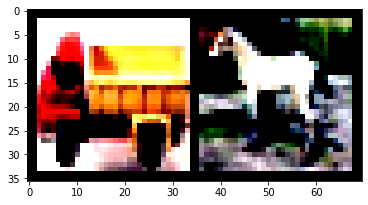

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from torch to plt image format
    plt.show()

# We get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# We show some images
imshow(utils.make_grid(images[0:2]))

## ResNet Implementation

We now implement our neuronal network: a ResNet model, that will permit to classify our images.

More precisely, we implement the 18-layers Resnet presented in the article by [Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun](https://arxiv.org/abs/1512.03385) (2015).

We implement the **convolutional block**, that will be repeated several times in the ResNet, following the recommendations of the article:
- we use 2 *convolutional layers*,
- each convolutional layer is followed by a *batch normalization*,
- the first convolutional layer output is activated by a *relu*,
- the second convolutional layer output is added to the *identity shortout connection*, before being activated by a *relu*.

In [5]:
# We implement the convalutional block just described

class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        # To avoid a dimensionality problem with the shortcut addition (when stride!=1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.shortcut(identity)
        x = self.relu(x)
        return x
 

We then implement the **ResNet18** by repeating several times the convalutional block, always following [Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun](https://arxiv.org/abs/1512.03385) (2015).

In [6]:
class ResNet(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet, self).__init__()

        ##########################################
        # Initial step: convolution + batch normalization + max pooling operation
        ##########################################
        # We have image_size = 32
        # thus output_size = (32 + 2x1 - 3)/1 + 1 = 32
        self.conv1 = nn.Conv2d(in_channels = image_channels, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) => better accuracy without


        ##########################################
        # Central step: convolutional blocks 
        ##########################################
        self.bigblock1 = nn.Sequential(
            ConvBlock(in_channels = 64, out_channels = 64, stride = 1),
            ConvBlock(64,64)
        )
        # We double the number of channels and take a stride of 2 to compensate for the volume increase:
        self.bigblock2 = nn.Sequential(
            ConvBlock(64,128, stride = 2),
            ConvBlock(128,128)
        )
        self.bigblock3 = nn.Sequential(
            ConvBlock(128,256, stride = 2),
            ConvBlock(256,256)
        )
        self.bigblock4 = nn.Sequential(
            ConvBlock(256,512, stride = 2),
            ConvBlock(512,512)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)  => better accuracy without
        
        x = self.bigblock1(x)
        x = self.bigblock2(x)
        x = self.bigblock3(x)
        x = self.bigblock4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 

We define the ResNet model with 10 classes output.

In [7]:
model = ResNet(image_channels = 3, num_classes = 10)

We use the *Cross Entropy* loss function and the *Adam* optimizer.

In [8]:
# We define the loss criterion
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=0.003)

# We use GPU if it's available, and the CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

## Training

We implement the training of our model, with the training and the validation datsets.



In [9]:
# Number of epochs used to train the model
n_epochs = 40

# Variables to keep track of the change in validation loss, to save the best model
valid_loss_min = np.Inf 
best_accuracy = 0.0

# Variables to keep the accuracies calculated at each epoch in order to plot them later
epoch_all = []  
valid_epoch_acc_all = []
train_epoch_acc_all = []

for epoch in range(1, n_epochs+1):

    # To keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    valid_running_corrects = 0
    train_running_corrects = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in trainloader:
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing images to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        # to calculate the training set accuracy later: 
        # take as prediction the label with highest output (highest probability)
        _, pred = torch.max(output, 1)
        # total number of correct predictions
        train_running_corrects += torch.sum(pred == labels)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in validloader:
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing images to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
        # to calculate the validation accuracy later: 
        # take as prediction the label with highest output (highest probability)
        _, pred = torch.max(output, 1)
        # total number of correct predictions
        valid_running_corrects += torch.sum(pred == labels)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    
    # calculate accuracy
    train_epoch_acc = train_running_corrects.double() / len(trainloader.sampler)
    valid_epoch_acc = valid_running_corrects.double() / len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss,valid_epoch_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar10.pt')
        valid_loss_min = valid_loss

    # We keep the accuracies at each epoch, to plot them later, and transfer them to the cpu
    # in order to convert the values into a numpy array and plot them
    epoch_all.append(epoch)    
    valid_epoch_acc_all.append(valid_epoch_acc.cpu())
    train_epoch_acc_all.append(train_epoch_acc.cpu())

Epoch: 1 	Training Loss: 1.593154 	Validation Loss: 1.379536 	Validation Accuracy: 0.492300
Validation loss decreased (inf --> 1.379536).  Saving model ...
Epoch: 2 	Training Loss: 1.083668 	Validation Loss: 0.994283 	Validation Accuracy: 0.643600
Validation loss decreased (1.379536 --> 0.994283).  Saving model ...
Epoch: 3 	Training Loss: 0.840565 	Validation Loss: 0.809601 	Validation Accuracy: 0.713900
Validation loss decreased (0.994283 --> 0.809601).  Saving model ...
Epoch: 4 	Training Loss: 0.671241 	Validation Loss: 0.663316 	Validation Accuracy: 0.767600
Validation loss decreased (0.809601 --> 0.663316).  Saving model ...
Epoch: 5 	Training Loss: 0.562290 	Validation Loss: 0.626984 	Validation Accuracy: 0.785400
Validation loss decreased (0.663316 --> 0.626984).  Saving model ...
Epoch: 6 	Training Loss: 0.468723 	Validation Loss: 0.614515 	Validation Accuracy: 0.792600
Validation loss decreased (0.626984 --> 0.614515).  Saving model ...
Epoch: 7 	Training Loss: 0.397285 	Vali

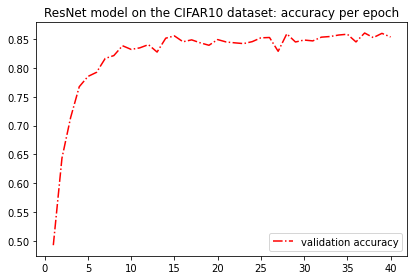

In [10]:
plt.plot(epoch_all, valid_epoch_acc_all, label="validation accuracy", color="red", linestyle='-.')
#plt.plot(epoch_all, train_epoch_acc_all, label="training accuracy", color="blue",linestyle='-.')
plt.title("ResNet model on the CIFAR10 dataset: accuracy per epoch")
plt.legend()
plt.tight_layout()
plt.show()

# Test of the model

We finally implement a test of the model accuracy, on the test dataset, that has not been used in the model training.

In [11]:
# We test our best model (the one with the lowest validation loss)
model.load_state_dict(torch.load('model_cifar10.pt'))


# To keep track of test loss and accuracy
test_loss = 0.0
test_running_corrects = 0


model.eval()
for images, labels in testloader:
    # move tensors to GPU if CUDA is available
    images, labels = images.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing images to the model
    output = model.forward(images)
    # calculate the batch loss
    loss = criterion(output, labels)
    # update average test loss 
    test_loss += loss.item()*images.size(0)
    # to calculate the test accuracy later: 
    # take as prediction the label with highest output (highest probability)
    _, pred = torch.max(output, 1)
    # total number of correct predictions
    test_running_corrects += torch.sum(pred == labels)


# calculate average loss
test_loss = test_loss/len(testloader.sampler)
    
# claculate accuracy
test_epoch_acc = test_running_corrects.double() / len(testloader.sampler)
        
# print training/validation statistics 
print('\tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(
    test_loss,test_epoch_acc))

	Test Loss: 0.488885 	Test Accuracy: 0.844500


We finally get a **84.5%** test accuracy with our model !